# Analyse des résultats

Importation des librairies nécessaires (pandas: importer et gérer des tableaux de données, seaborn et matplotlib pour les graphiques)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

Fonctions


In [2]:
def create_df(string_location_file, string_file_name, sheet_name):
    df_testType = pd.read_excel(string_location_file + string_file_name, sheet_name=sheet_name,skiprows=2)
    return df_testType

def import_data_from_excel(string_location_file, string_file_name):
    dico_df={}
    for test_type in ["Action","4_words","list","3_infos","repeatability_list"]:
        dico_df[test_type]=create_df(string_location_file, string_file_name, test_type)
    return dico_df

def calculatePercentage(df, column, valueToCount, totalForPercentage):
    occurenceValueToCountInCol = len(df[df[column].str.lower().isin([valueToCount])])
    percent=occurenceValueToCountInCol*100/totalForPercentage
    return percent

def savePercentage (df_whereSaved, columnCritere, valueCritere, df_percent, columnPercent, valueToCount, totalForPercentage, nameNewCol):
    float_percent = calculatePercentage(df_percent, columnPercent, valueToCount, totalForPercentage)
    df_whereSaved.loc[ (df_whereSaved[columnCritere]==valueCritere), nameNewCol] = float_percent
    return

def createTemporaryDf(df_input,string_colCritere1, valueCritere1, string_colCritere2, valueCritere21, valueCritere22, critere2=False):
    lst_df_temp=[]

    df_temp1=df_input[df_input[string_colCritere1]==valueCritere1]
    lst_df_temp.append(df_temp1)

    if critere2:
        df_temp21=df_temp1[df_temp1[string_colCritere2]==valueCritere21]
        df_temp22=df_temp1[df_temp1[string_colCritere2]==valueCritere22]
        lst_df_temp.append(df_temp21)
        lst_df_temp.append(df_temp22)

    return lst_df_temp

#ecrase la premiere fonction savePercentage?
def savePercentage (df_whereSaved, string_col1, valueCol1, string_col2, valueCol2, string_nameNewCol, float_percent):
    df_whereSaved.loc[ (df_whereSaved[string_col1]==valueCol1) & (df_whereSaved[string_col2]==valueCol2),string_nameNewCol] = float_percent
    return

Initialisation: variables globale (temporaires, à supprimer dès que possible) et chemin d'acces au fichier.

In [3]:
#location=
file_name="Tests results.xlsx"
nbVideos=9
nbRep=5

Importation des données dans des data frame et formatage pour être facilement utilisées.

In [4]:
#dico_df=import_data_from_excel("C:/Users/camil/Documents/PERSO/COURS/H-KA/COURS/MechaSysteme/Project/", "Tests results.xlsx")
dico_df=import_data_from_excel("/Users/mariewinkler/Documents/HKA/S2/Mechatronische Systeme/Projekt/", "Tests results.xlsx")
df_action=dico_df["Action"]
df_action["test_type"]="Action"

df_4Words=dico_df["4_words"]
df_4Words["test_type"]="4Words"

df_list=dico_df["list"]
df_list["test_type"]="list"

df_3Infos=dico_df["3_infos"]
df_3Infos["test_type"]="3Infos"

df_repeatability_list= dico_df["repeatability_list"]
df_3Infos["test_type"]="repeatability_list"

df_poe=pd.concat([df_action[df_action["LLM"]=="Poe"],df_4Words[df_4Words["LLM"]=="Poe"],
                 df_list[df_list["LLM"]=="Poe"],df_3Infos[df_3Infos["LLM"]=="Poe"]],join="inner", ignore_index=True)
df_hf=pd.concat([df_action[df_action["LLM"]=="Hugging Faces"],df_4Words[df_4Words["LLM"]=="Hugging Faces"],
                 df_list[df_list["LLM"]=="Hugging Faces"],df_3Infos[df_3Infos["LLM"]=="Hugging Faces"]],join="inner", ignore_index=True)



Lignes de code pour tracer les graphiques. Une erreur et de toute façon, la présentation est moche. Il faut faire des fonctions.

dict_keys(['Action', '4_words', 'list', '3_infos', 'repeatability_list'])
Processing test_type = Action


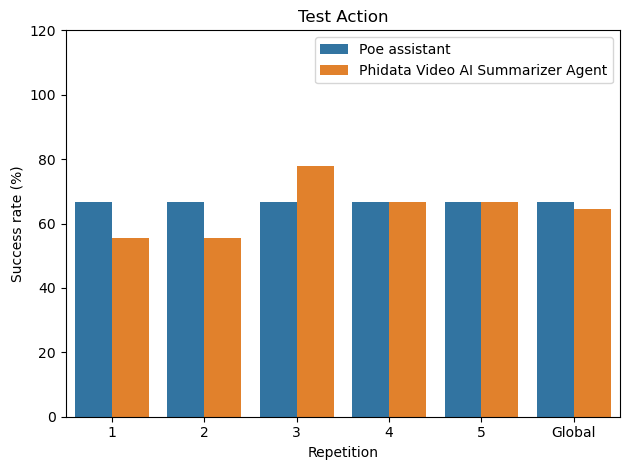

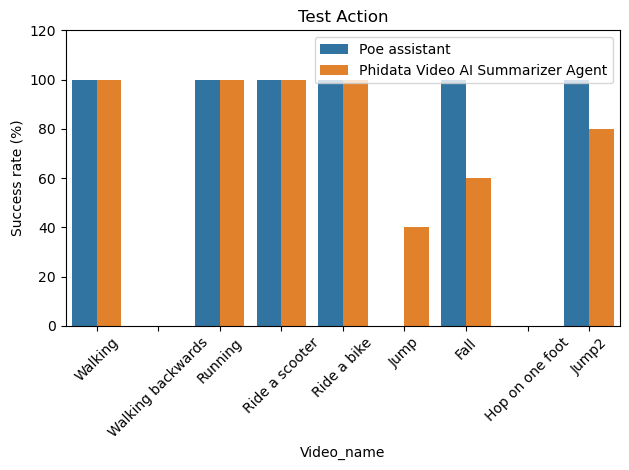

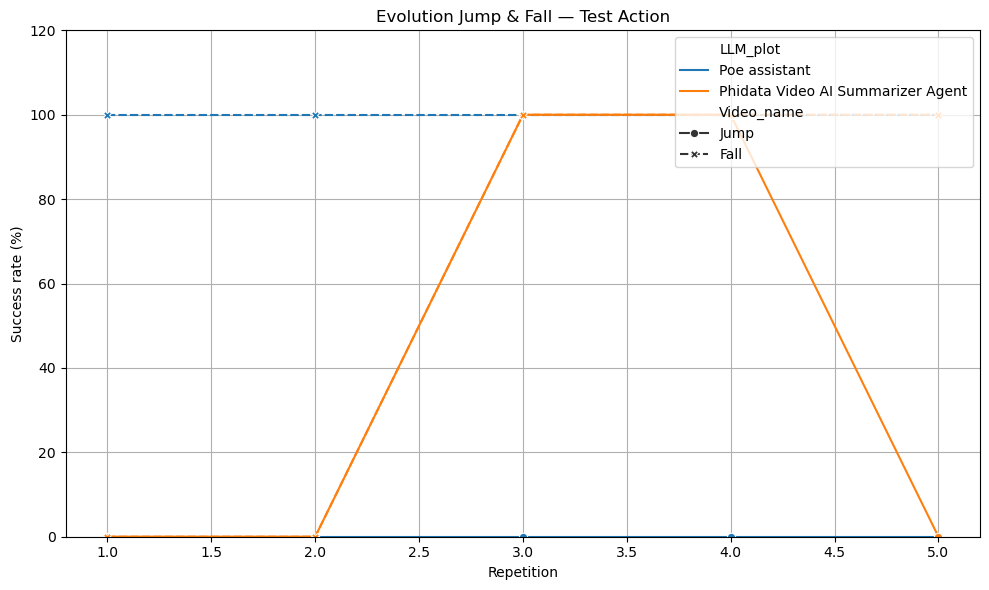

Processing test_type = 4_words


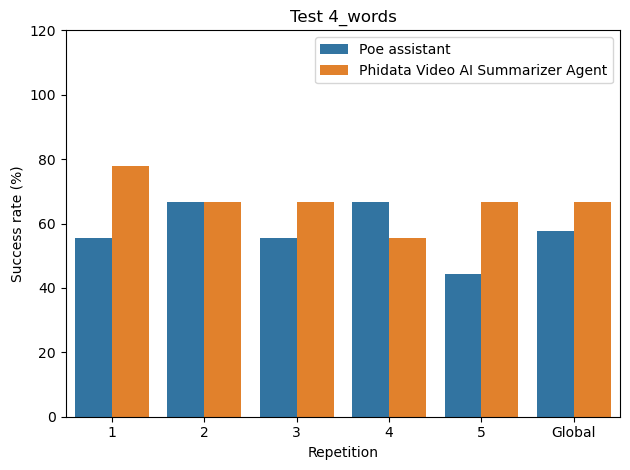

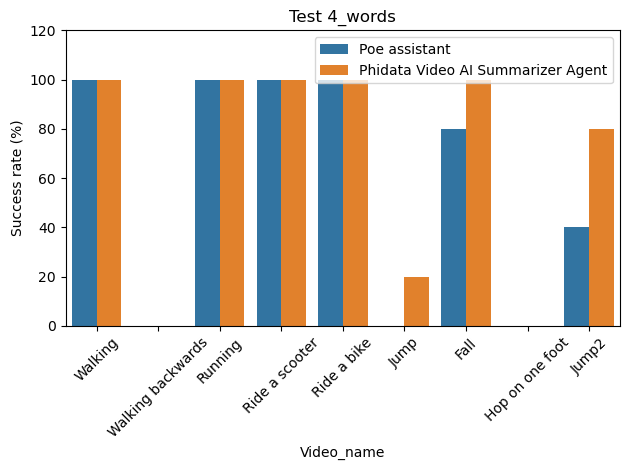

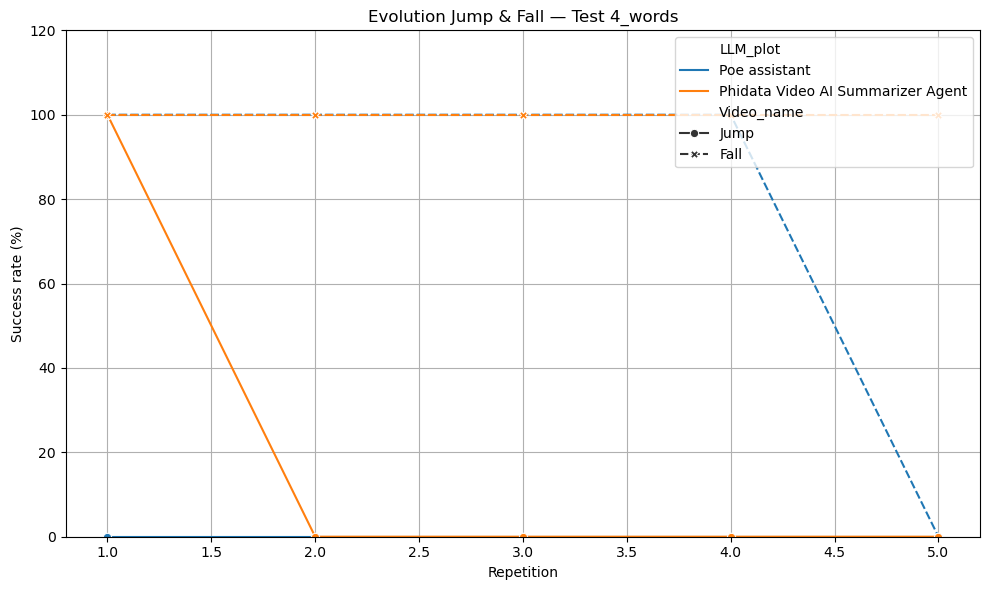

Processing test_type = list


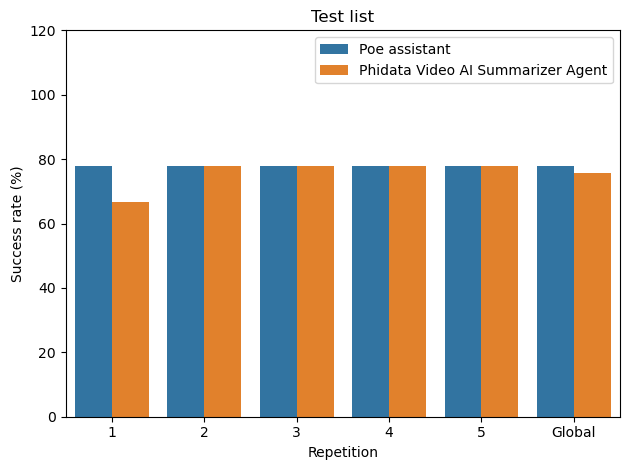

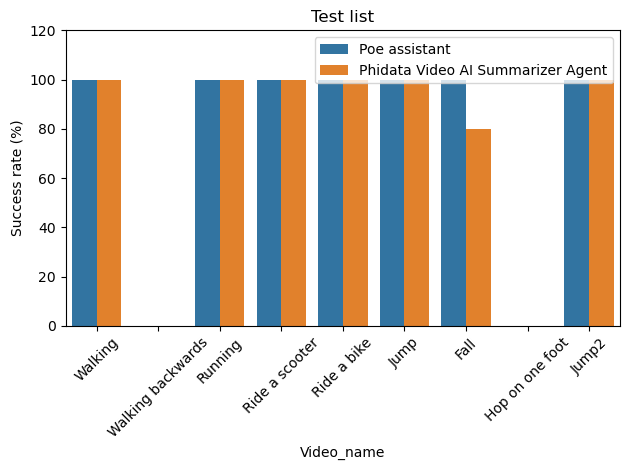

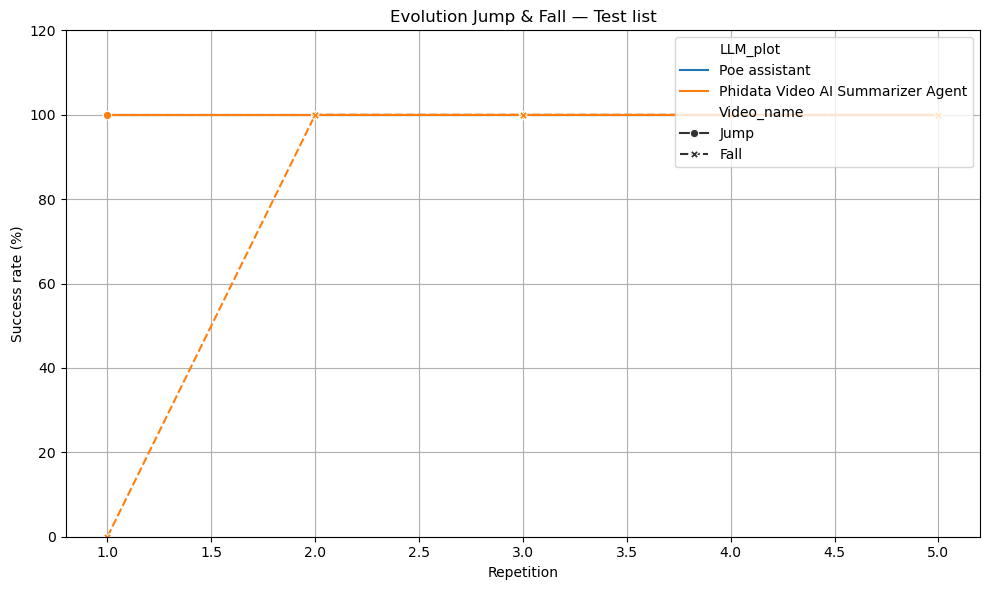

Processing test_type = 3_infos


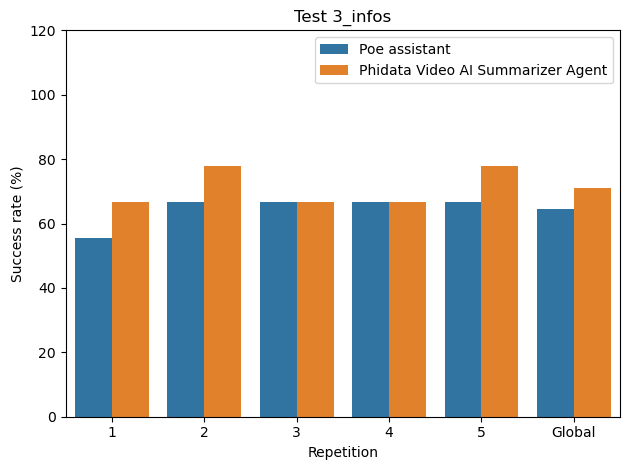

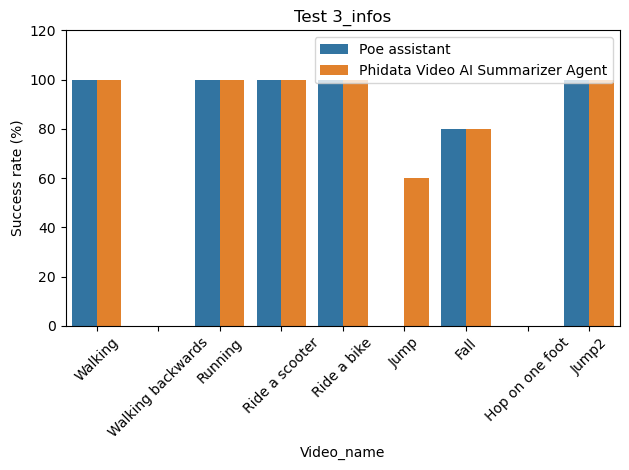

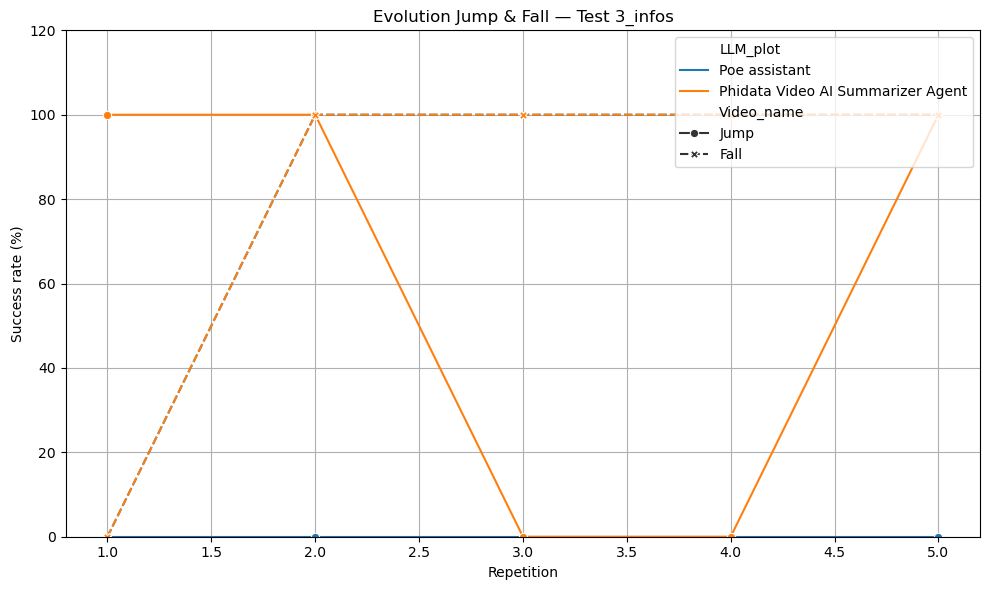

Processing test_type = repeatability_list


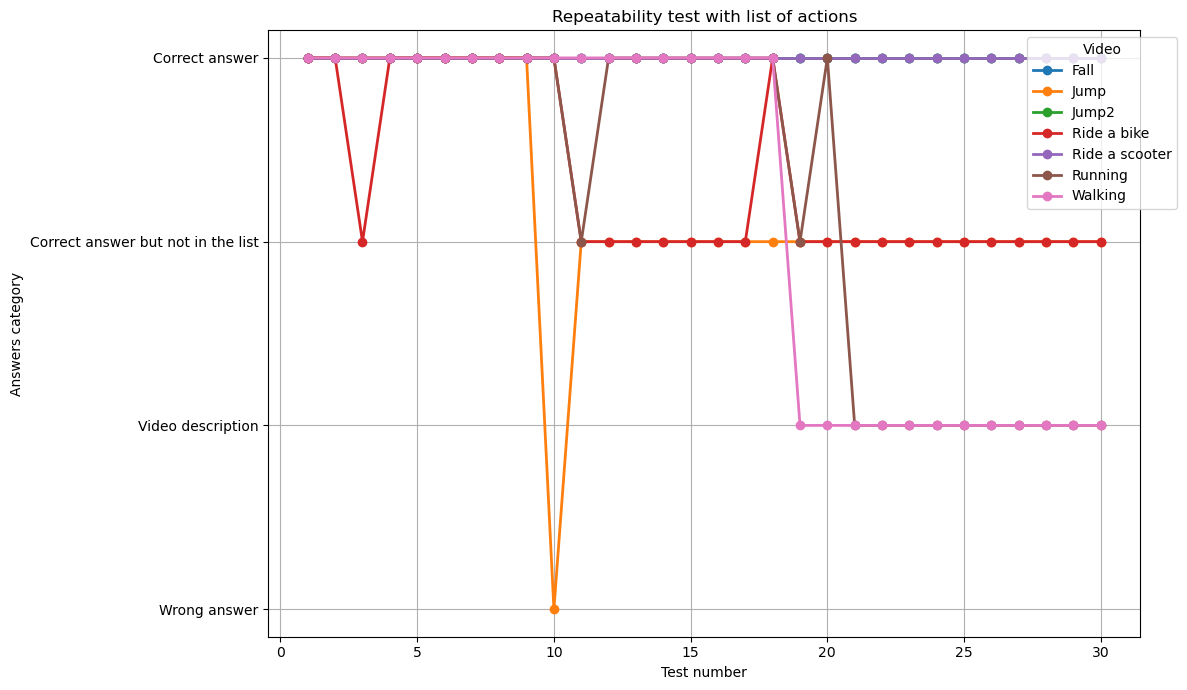

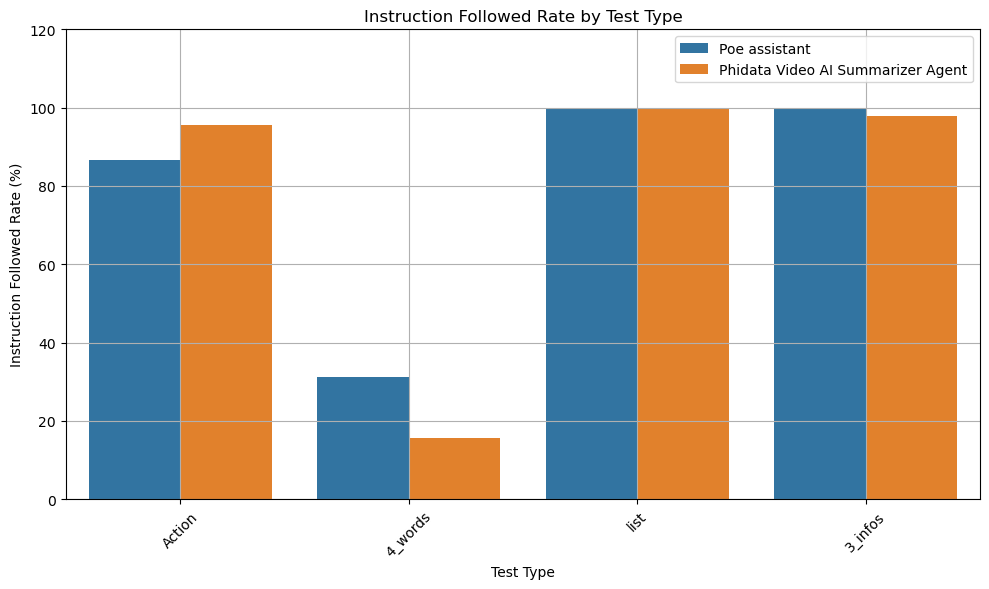

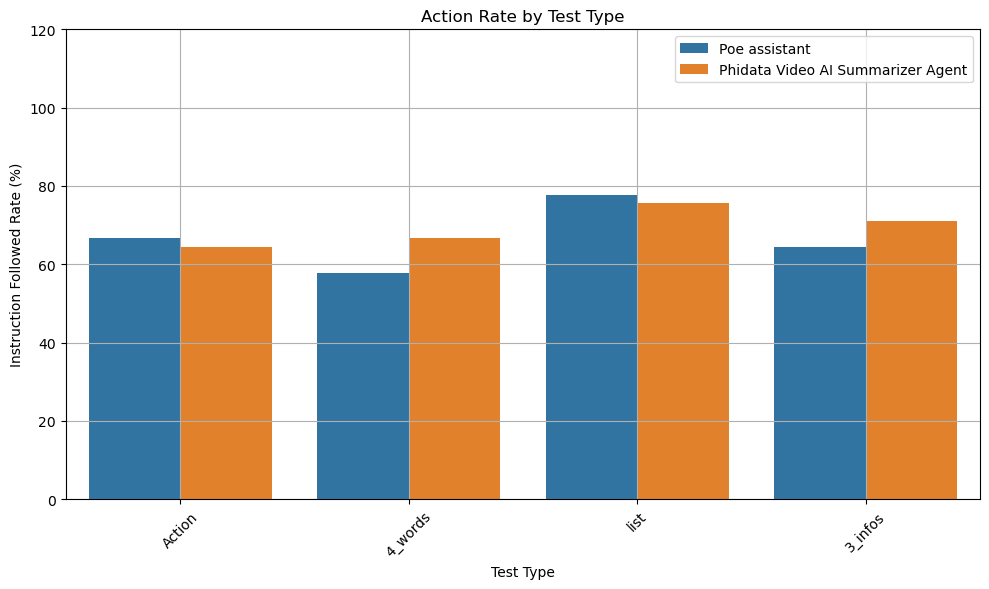

In [ ]:
# Mapping of video IDs to names
video_names = {
    1: "Walking",
    5: "Walking backwards",
    10: "Running",
    14: "Ride a scooter",
    19: "Ride a bike",
    23: "Jump",
    7: "Jump2",
    28: "Fall",
    32: "Hop on one foot"
}

summary_instr = []  # To store global Instruction Followed rates by test_type

i = 0
print(dico_df.keys())

for test_type in list(dico_df.keys()):
    df_test = dico_df[test_type]
    name = list(dico_df.keys())[i]
    print(f"Processing test_type = {name}")

    # Map video IDs to video names
    df_test["Video_name"] = df_test["Video"].map(video_names)

    # --- Special case for repeatability_list ---
    if test_type == "repeatability_list":
        all_data = []
        for video in df_test["Video"].dropna().unique():
            lst = createTemporaryDf(df_test, "Video", video, "LLM", "Poe", "Hugging Faces", critere2=False)
            df_video = lst[0].copy()
            if "Test" not in df_video.columns or "Answers categorie" not in df_video.columns:
                continue
            df_video["Video"] = video
            df_video["Video_name"] = video_names.get(video, str(video))
            all_data.append(df_video)
        if not all_data:
            i += 1
            continue
        df_all = pd.concat(all_data, ignore_index=True)
        df_all = df_all[df_all["Test"] <= 30].dropna(subset=["Answers categorie"])
        cat_order = [
            "Wrong answer",
            "Video description",
            "Correct answer but not in the list",
            "Correct answer"
        ]
        cat_to_num = {cat: idx for idx, cat in enumerate(cat_order)}
        df_all["Answers_categorie_num"] = df_all["Answers categorie"].map(cat_to_num).dropna()
        plt.figure(figsize=(12, 7))
        for video_name, grp in df_all.groupby("Video_name"):
            grp = grp.sort_values("Test")
            plt.plot(grp["Test"], grp["Answers_categorie_num"], label=video_name, marker='o', linewidth=2)
        plt.yticks(range(len(cat_order)), cat_order)
        plt.title("Repeatability test with list of actions")
        plt.xlabel("Test number")
        plt.ylabel("Answers category")
        plt.legend(title="Video", bbox_to_anchor=(1.05, 1), loc='upper right')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        i += 1
        continue

    # --- Calculation per repetition (Action ok?) ---
    for rep in range(1, 6):
        lst = createTemporaryDf(df_test, "Test", rep, "LLM", "Poe", "Hugging Faces", critere2=True)
        percentPoe = calculatePercentage(lst[1], 'Action ok?', "yes", nbVideos)
        percentHF = calculatePercentage(lst[2], 'Action ok?', "yes", nbVideos)
        savePercentage(df_test, "Test", rep, "LLM", "Poe", "percentYes", percentPoe)
        savePercentage(df_test, "Test", rep, "LLM", "Hugging Faces", "percentYes", percentHF)

    # --- Global Action ok? + Instruction followed? ---
    for llm in ["Poe", "Hugging Faces"]:
        df_llm = df_test[df_test["LLM"] == llm]
        global_action = calculatePercentage(df_llm, 'Action ok?', "yes", len(df_llm))
        global_instr = calculatePercentage(df_llm, 'Instruction followed?', "yes", len(df_llm))
        global_row = {
            "Test": "Global",
            "LLM": llm,
            "percentYes": global_action,
            "Video": -1,
            "Video_name": None,
            "perVideo_percentYes": None,
            "perVideo_percentYes_instruction": global_instr,
            "Action ok?": None
        }
        df_test = pd.concat([df_test, pd.DataFrame([global_row])], ignore_index=True)
        summary_instr.append({
            "Test_type": name,
            "LLM": llm,
            "InstructionFollowedRate": global_instr,
            "ActionPredictedRate": global_action
        })


    # --- Plot Action ok? by repetition ---
    plt.figure()
    plt.title(f"Test {name}")
    df_plot = df_test.copy()
    df_plot["LLM_plot"] = df_plot["LLM"].replace({
        "Poe": "Poe assistant",
        "Hugging Faces": "Phidata Video AI Summarizer Agent"
    })
    sns.barplot(data=df_plot, x="Test", y="percentYes", hue="LLM_plot", dodge=True)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.set_ylim(0, 120)
    plt.xlabel("Repetition")
    plt.ylabel("Success rate (%)")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    # --- Calculation per video (Action ok? + Instruction followed?) ---
    for video in df_test["Video"].dropna().unique():
        if video == -1:
            continue
        lst = createTemporaryDf(df_test, "Video", video, "LLM", "Poe", "Hugging Faces", critere2=True)
        pP = calculatePercentage(lst[1], 'Action ok?', "yes", nbRep)
        pH = calculatePercentage(lst[2], 'Action ok?', "yes", nbRep)
        savePercentage(df_test, "Video", video, "LLM", "Poe", "perVideo_percentYes", pP)
        savePercentage(df_test, "Video", video, "LLM", "Hugging Faces", "perVideo_percentYes", pH)

    # --- Bar plots per video ---
    plt.figure()
    plt.title(f"Test {name}")
    df_plot = df_test.copy()
    df_plot["LLM_plot"] = df_plot["LLM"].replace({
        "Poe": "Poe assistant",
        "Hugging Faces": "Phidata Video AI Summarizer Agent"
    })
    sns.barplot(data=df_plot, x="Video_name", y="perVideo_percentYes", hue="LLM_plot", dodge=True)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.set_ylim(0, 120)
    plt.xticks(rotation=45)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.ylabel("Success rate (%)")
    plt.show()

    # --- Jump + Fall cases by repetition (unchanged) ---
    list_rows = []
    target_videos = [23, 28]
    for rep in range(1, 6):
        for video in target_videos:
            for llm in ["Poe", "Hugging Faces"]:
                lst = createTemporaryDf(df_test, "Test", rep, "LLM", "Poe", "Hugging Faces", critere2=True)
                df_llm = lst[1] if llm == "Poe" else lst[2]
                df_vid = df_llm[df_llm["Video"] == video]
                pct = calculatePercentage(df_vid, 'Action ok?', "yes", len(df_vid)) if len(df_vid) else 0
                list_rows.append({
                    "Test": rep,
                    "Video": video,
                    "Video_name": video_names.get(video, str(video)),
                    "LLM": llm,
                    "percentYes": pct
                })
    df_per_rep_vid = pd.DataFrame(list_rows)
    plt.figure(figsize=(10, 6))
    plt.title(f"Evolution Jump & Fall — Test {name}")
    df_per_rep_vid_plot = df_per_rep_vid.copy()
    df_per_rep_vid_plot["LLM_plot"] = df_per_rep_vid_plot["LLM"].replace({
        "Poe": "Poe assistant",
        "Hugging Faces": "Phidata Video AI Summarizer Agent"
    })
    sns.lineplot(data=df_per_rep_vid_plot, x="Test", y="percentYes", hue="LLM_plot", style="Video_name", markers=True)
    plt.xlabel("Repetition")
    plt.ylabel("Success rate (%)")
    plt.ylim(0, 120)
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    i += 1  # Move to the next test_type

# --- Final summary Instruction followed? by test_type ---
if summary_instr:
    df_summary = pd.DataFrame(summary_instr)

    # Ajout du global : moyenne par LLM tous test_types confondus
    df_global = df_summary.groupby("LLM", as_index=False)[["InstructionFollowedRate", "ActionPredictedRate"]].mean()
    df_global["Test_type"] = "Global"
    df_summary = pd.concat([df_summary, df_global], ignore_index=True)

    df_summary_plot = df_summary.copy()
    df_summary_plot["LLM_plot"] = df_summary_plot["LLM"].replace({
        "Poe": "Poe assistant",
        "Hugging Faces": "Phidata Video AI Summarizer Agent"
    })

    # --- Instruction Followed Rate ---
    plt.figure(figsize=(10, 6))
    plt.title("Instruction Followed Rate by Test Type")
    sns.barplot(data=df_summary_plot, x="Test_type", y="InstructionFollowedRate", hue="LLM_plot", dodge=True)
    plt.xticks(rotation=45)
    plt.ylim(0, 120)
    plt.xlabel("Test Type")
    plt.ylabel("Instruction Followed Rate (%)")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.grid(True)
    plt.show()

    # --- Action Rate (Action ok?) ---
    plt.figure(figsize=(10, 6))
    plt.title("Action Rate by Test Type")
    sns.barplot(data=df_summary_plot, x="Test_type", y="ActionPredictedRate", hue="LLM_plot", dodge=True)
    plt.xticks(rotation=45)
    plt.ylim(0, 120)
    plt.xlabel("Test Type")
    plt.ylabel("Action Rate (%)")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.grid(True)
    plt.show()

Brouillon


In [6]:
# def prepareDf(df_testType, x, y, hue, perRep=True, perVideo=False):
#     lst_rep=[k for k in range(1,6)]
#     lst_Video=df_testType["Video"].unique()

#     if perRep:
#         for rep in lst_rep:
#             lst_tempDF=createTemporaryDf(df_testType,"Test",rep,"LLM","Poe","Hugging Faces", critere2=True)

#             percentPoe = calculatePercentage(lst_tempDF[1],'Action ok?', "Yes", nbVideos)
#             percentHF = calculatePercentage(lst_tempDF[2],'Action ok?', "Yes", nbVideos)

#             savePercentage (df_action,"Test",rep,"LLM", "Poe", "percentYes", percentPoe)
#             savePercentage (df_action,"Test",rep,"LLM", "Hugging Faces", "percentYes", percentHF)

#     return

# df_byrep = df_action[df_action["Test"]==rep]
    # df_byrep_bypoe=df_byrep[df_byrep["LLM"]=="Poe"]
    # df_byrep_byhf=df_byrep[df_byrep["LLM"]=="Hugging Faces"]
    # occurencepoeYes = len(df_byrep_bypoe[df_byrep_bypoe['Action ok?'].isin(["Yes"])])
    # occurencehfYes = len(df_byrep_byhf[df_byrep_byhf['Action ok?'].isin(["Yes"])])
    # print(occurencepoeYes)
    # print(occurencehfYes)
    # df_action.loc[ (df_action["Test"]==rep) & (df_action["LLM"]=="Poe"),"occurenceYes"] = occurencepoeYes
    # df_action.loc[ (df_action["Test"]==rep) & (df_action["LLM"]=="Hugging Faces"),"occurenceYes"] = occurencehfYes